# Notebook d'entrainement du modèle

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torchvision.models import mobilenet_v3_small

## 1. Exploration des données

In [50]:
# 1 ligne = 1 image (28*28 pixels = 784 pixels), 1 colonne = 1 pixel ; 

train = pd.read_csv('../data/fashion-mnist_train.csv')
test = pd.read_csv('../data/fashion-mnist_test.csv')
print(f"{train.shape[0]:_} images dans le jeu d'entrainement")
print(f"{test.shape[0]:_} images dans le jeu de test")
train.head()

60_000 images dans le jeu d'entrainement
10_000 images dans le jeu de test


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# analyse de la cible : 10 labels parfaitement équilibrés 

# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

train['label'].value_counts(normalize=True)

label
2    0.1
9    0.1
6    0.1
0    0.1
3    0.1
4    0.1
5    0.1
8    0.1
7    0.1
1    0.1
Name: proportion, dtype: float64

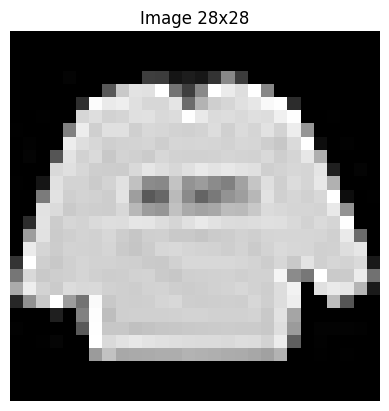

In [ ]:
# Affichage d'une image 

image_flat = train.drop(columns=['label']).loc[0].to_numpy()
image = image_flat.reshape(28, 28)

plt.imshow(image, cmap='gray')
plt.title("Image 28x28")
plt.axis('off')
plt.show()

## 2. Préparation des données

In [53]:
# Définition des transformations (Fashion MNIST 28x28 → MobileNetV3 attend 224x224 RGB)

transform = transforms.Compose([
    transforms.Resize((224, 224)),# resize images 28x28 → 224x224
    transforms.Grayscale(num_output_channels=3),  # convertir 1 canal → 3 canaux RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # normalisation ImageNet
                         std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Chargement des datasets transformées 

train_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # pour traiter les données par batch
test_loader = DataLoader(test_dataset, batch_size=64)

100.0%
100.0%
100.0%
100.0%


## 3. Chargement du modèle de Deep Learning pré-entrainé

Modèle choisi : MobileNetV3 small 

- très léger 
- rapide à entrainer (entrainement sur CPU)
- suffisamment puissant pour Fashion MNIST

In [55]:
# MobileNetV3 small pré-entrainé
model = models.mobilenet_v3_small(pretrained=True)

c:\Users\hermi\Documents\Semaine 12\Dojo\fashion-mnist-classifier\env_fashion\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hermi\Documents\Semaine 12\Dojo\fashion-mnist-classifier\env_fashion\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
1.3%

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\hermi/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth


100.0%


In [ ]:
# Gele toutes les couches du modèle (y compris classifier)
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Remplace la dernière couche (Linear) par notre couche 10 classes
num_features = model.classifier[3].in_features  # récupération du nombre d'entrées
model.classifier[3] = nn.Linear(num_features, 10)

In [ ]:
# Dégèle uniquement les paramètres de la nouvelle tête pour l'entraînement
for param in model.classifier.parameters():
    param.requires_grad = True

In [60]:
device = torch.device('cpu')
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

## 4. Entrainement

In [59]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


for epoch in range(5):
    print(f"Epoch {epoch+1}/5")
    train_one_epoch(model, train_loader, criterion, optimizer, device)

Epoch 1/5
Train Loss: 0.4557 Acc: 0.8371
Epoch 2/5
Train Loss: 0.3405 Acc: 0.8758
Epoch 3/5
Train Loss: 0.3012 Acc: 0.8896
Epoch 4/5
Train Loss: 0.2774 Acc: 0.8975
Epoch 5/5
Train Loss: 0.2613 Acc: 0.9037


In [62]:
# Sauvegarde des poids 
weight_path = '../model/mobilenetv3_fashionmnist.pth'

torch.save(model.state_dict(), weight_path)

## 5. Evaluation des performances du modèle

In [63]:
# Chargement du modèle à partir des poids fine-tunés :

model_ft = mobilenet_v3_small(pretrained=False)
num_features = model_ft.classifier[3].in_features
model_ft.classifier[3] = torch.nn.Linear(num_features, 10)

model_ft.load_state_dict(torch.load(weight_path))
model_ft.eval()

c:\Users\hermi\Documents\Semaine 12\Dojo\fashion-mnist-classifier\env_fashion\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hermi\Documents\Semaine 12\Dojo\fashion-mnist-classifier\env_fashion\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
y_true = []
y_pred = []

with torch.no_grad():  # pas besoin de gradients pendant l'évaluation
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_ft(images)  # shape: (batch_size, 10)

        # Prédictions = classe avec probabilité maximale
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [68]:
print(f"Test accuracy: {accuracy_score(y_true, y_pred):.4f}")

Test accuracy: 0.8950


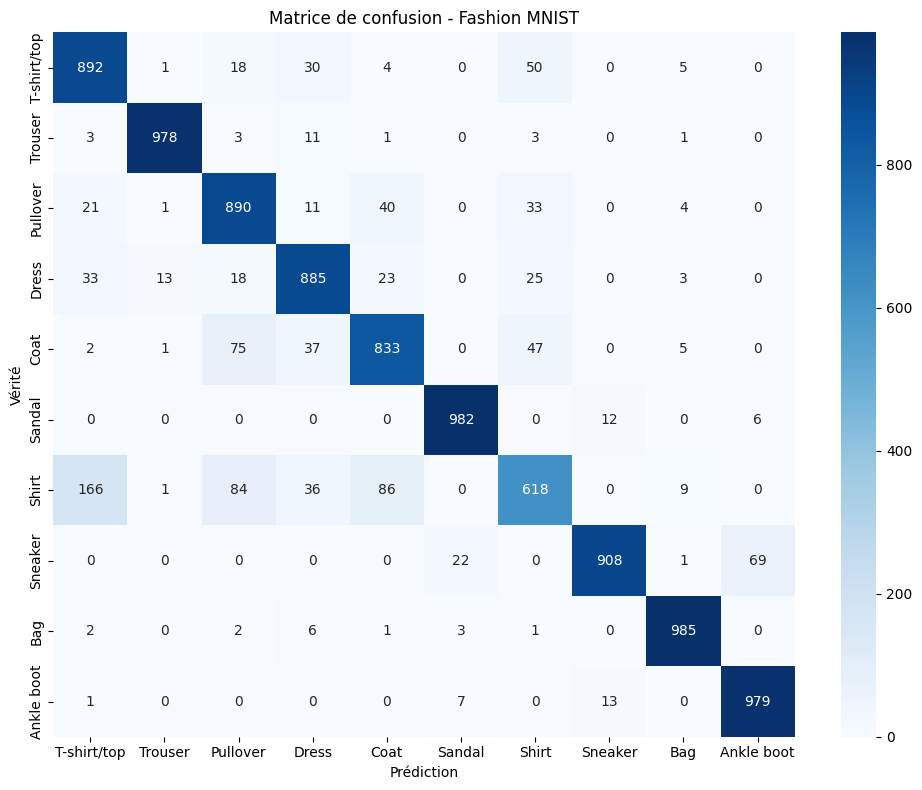

In [83]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

cm = confusion_matrix(y_true, y_pred)

# Affichage avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.title('Matrice de confusion - Fashion MNIST')
plt.tight_layout()

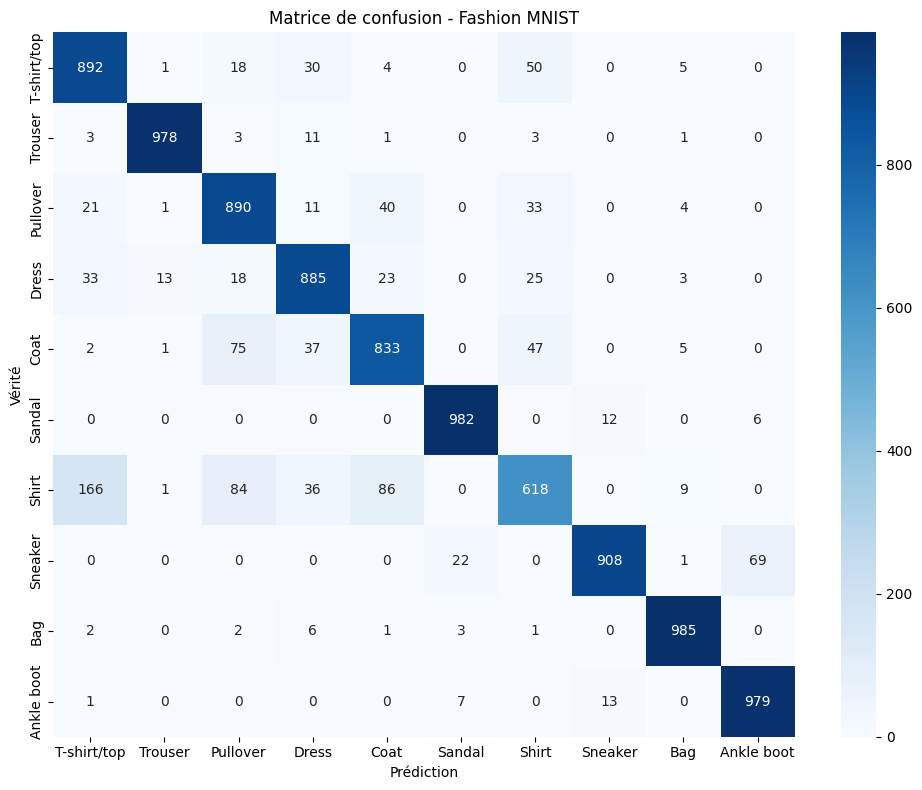

In [86]:
# Matrice de confusion : 

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

cm = confusion_matrix(y_true, y_pred)

# Affichage avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Prédiction')
plt.ylabel('Vérité')
plt.title('Matrice de confusion - Fashion MNIST')
plt.tight_layout()

plt.savefig('confusion_matrix.png')

Conclusions : 

- le modèle confond beaucoup "Tshirt/top" avec "shirt" 
- "shirt" prédit comme "pullover", "coat"
- "sneaker" prédit comme "ankle boot"
- "coat" prédit comme "pullover"

## 6. Prédiction sur une image

In [ ]:
with torch.no_grad():
    x, _ = test_dataset[0]  # ou autre index
    x = x.unsqueeze(0).to(device)  # ajoute la dimension batch
    output = model(x)
    probs = torch.softmax(output.squeeze(0), dim=0)
    predicted_class = torch.argmax(probs).item()